# Running the final (best selected) models for comparison between conditions / assessing coefficient

In [5]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

import pingouin as pg

In [6]:
# grab data
df = pd.read_csv('../../scr_amg_hipp_all.csv')

In [3]:
df.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,pe,scr,index,subject,trialNo,condition,coupling,amg,Sub,group,Eprime,amg_vmpfc,amg_HippAnt,amg_ctrl
0,sub-189,CSplusUS1,1,0.2852,0.801175,0.500000,0.2852,1794,sub-189,1,CSplusUS1,0.309524,0.981121,sub-189,HC,A,0.904762,0.571429,0.523810
1,sub-189,CSminus1,2,0.1033,0.796939,-0.500000,0.1033,1795,sub-189,2,CSminus1,-0.571429,-0.027048,sub-189,HC,A,0.404762,-0.119048,0.404762
2,sub-189,CSplus1,3,0.0783,0.799047,-0.501304,0.0783,1796,sub-189,3,CSplus1,-0.476190,-0.045910,sub-189,HC,A,0.333333,-0.642857,0.119048
3,sub-189,CSplusUS1,4,0.1772,0.801165,0.500006,0.1772,1797,sub-189,4,CSplusUS1,0.166667,-0.674150,sub-189,HC,A,0.690476,0.357143,0.285714
4,sub-189,CSminus1,5,0.0000,0.794832,-0.498696,0.0000,1798,sub-189,5,CSminus1,0.214286,-0.065602,sub-189,HC,A,0.595238,0.309524,0.214286


In [7]:
# organize data for the Bayes analysis
df['sub'] = df['sub'].astype('category')
#df['condition'] = df['condition'].astype('category')

n_sub = len(df['sub'].unique())
subIDX = df['sub'].cat.codes.values
# condition
n_cond = len(df['condition'].unique())
#condIDX = df['condition'].cat.codes.values
trials = df.trialNo.values - 1
amygdala = df.amg.values
df['cond'] = df['condition']#
df = df.replace(to_replace={'cond': {'CSminus1':0, 'CSplus1':1, 'CSplusUS1':2, 'CSplus2':3, 'CSminus2':4, 'CSminusUS2':5}})
condIDX = df.cond.values

In [16]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as model:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
   
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.coupling)
    
    trace = pm.sample(target_accept=.95, chains=4, cores=4, return_inferencedata=True, draws=2000, tune=2000, random_seed=123)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 421 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [17]:
az.summary(trace, var_names=['b_cond'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_cond[0],0.014,0.36,-0.681,0.679,0.007,0.005,2819.0,3978.0,1.0
b_cond[1],-0.006,0.36,-0.705,0.651,0.007,0.005,2845.0,3811.0,1.0
b_cond[2],0.087,0.36,-0.598,0.757,0.007,0.005,2862.0,3905.0,1.0
b_cond[3],-0.025,0.36,-0.707,0.655,0.007,0.005,2854.0,4090.0,1.0
b_cond[4],-0.020,0.36,-0.702,0.661,0.007,0.005,2837.0,3930.0,1.0
b_cond[5],0.054,0.36,-0.594,0.767,0.007,0.005,2837.0,3772.0,1.0


In [18]:
trStacked = trace.posterior.stack(draws=('chain','draw'))
csminus1 = trStacked.b_cond[0,:].values
csplus1 = trStacked.b_cond[1,:].values
csPlusUS1 = trStacked.b_cond[2,:].values
csminus2 = trStacked.b_cond[4,:].values
csplus2 = trStacked.b_cond[3,:].values
csPlusUS2 = trStacked.b_cond[5,:].values
csUSboth = np.mean(np.stack([csPlusUS1, csPlusUS2]), axis=0) # averaging across USs
csall = np.mean(np.stack([csminus1,csminus2, csplus1, csplus2]), axis=0) # averaging across CSs
usVcs = csUSboth - csall

Text(0.5, 1.0, 'CSPlusUS-CS')

<Figure size 1296x216 with 0 Axes>

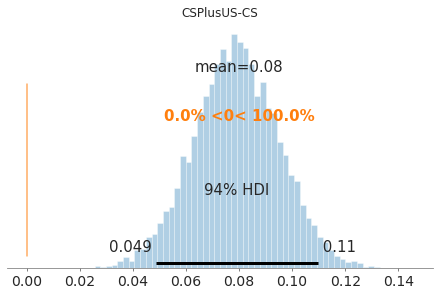

In [19]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(usVcs, point_estimate='mean', kind='hist', ref_val=0).set_title("CSPlusUS-CS")

In [20]:
print(f'Standardized coeficient {np.mean(usVcs) / np.std(usVcs)}')
az.summary(usVcs)

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


Standardized coeficient 4.963066644001489


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.08,0.016,0.049,0.11,0.0,0.0,6154.0,4978.0,NaN


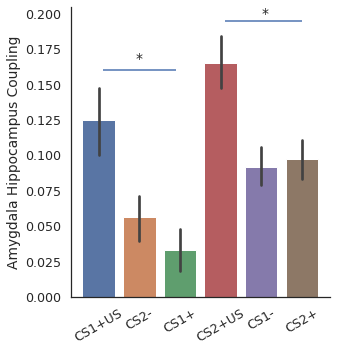

In [48]:
# visualization
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='coupling',x='condition', data=df, kind='bar', ci=68)
g.set_xlabels("")
g.set_xticklabels(
    labels=["CS1+US", "CS2-", "CS1+", "CS2+US", "CS1-", "CS2+"], rotation=30)
plt.text(0.9, 0.165, "*")
plt.hlines(0.16, 0.1,1.9)
plt.text(4, 0.197, "*")
plt.hlines(0.195, 3.1,5)
g.set_ylabels("Amygdala Hippocampus Coupling")
g.savefig('coupling_different_Conditions.png', dpi=300, bbox_inches='tight')

## SCR and amg-hippocampus

In [36]:
# first we need to remove shock trials (as SCR in shock trials is not reliable)
df_noShock = df[(df['condition']!='CSplusUS1') & (df['condition']!='CSminusUS2')]

In [38]:
df_noShock.Condition

1       CSminus1
2        CSplus1
4       CSminus1
5        CSplus1
6        CSplus1
          ...   
4480     CSplus2
4481    CSminus2
4482    CSminus2
4483     CSplus2
4484    CSminus2
Name: Condition, Length: 3640, dtype: object

In [39]:
df_noShock['sub'] = df_noShock['sub'].astype('category')
#df['condition'] = df['condition'].astype('category')

n_subNoShock = len(df_noShock['sub'].unique())
subIDX_NoShock = df_noShock['sub'].cat.codes.values
# condition
n_cond_noShock = len(df_noShock['condition'].unique())
#condIDX = df['condition'].cat.codes.values
trials_noShock = df_noShock.trialNo.values - 1
amygdala_NoShock = df_noShock.amg.values
df_noShock['cond'] = df_noShock['condition']#
df_noShock = df_noShock.replace(to_replace={'cond': {'CSminus1':0, 'CSplus1':1, 'CSplus2':2, 'CSminus2':3}})
condIDX_noShock = df_noShock.cond.values

/tmp/ipykernel_6559/1890040735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noShock['sub'] = df_noShock['sub'].astype('category')
/tmp/ipykernel_6559/1890040735.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noShock['cond'] = df_noShock['condition']#


In [40]:
with pm.Model() as model1_scr:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_subNoShock)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond_noShock)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX_NoShock] + b_cond[condIDX_noShock] + b_trials*trials_noShock + b_amg*df_noShock.amg + b_coup*df_noShock.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df_noShock.scr)
   
    
    trace_scr = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 329 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [41]:
az.summary(trace_scr, var_names=['mu_a','b_coup', 'b_cond'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,0.294,0.358,-0.399,0.944,0.006,0.004,4178.0,3606.0,1.0
b_coup,0.030,0.021,-0.010,0.069,0.000,0.000,9104.0,6075.0,1.0
b_cond[0],0.137,0.359,-0.537,0.806,0.006,0.005,4112.0,3735.0,1.0
b_cond[1],0.362,0.359,-0.303,1.039,0.006,0.004,4091.0,3649.0,1.0
b_cond[2],0.333,0.360,-0.342,1.007,0.006,0.004,4083.0,3717.0,1.0
b_cond[3],0.427,0.360,-0.269,1.077,0.006,0.004,4097.0,3600.0,1.0


<AxesSubplot:title={'center':'b_coup'}>

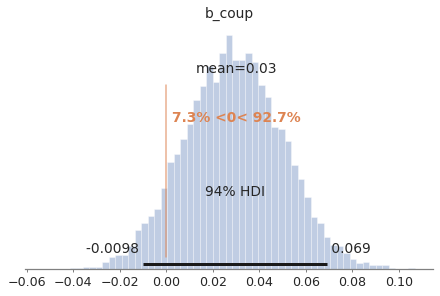

In [42]:
sns.set_style("ticks")
az.plot_posterior(trace_scr, var_names=['b_coup'], kind='hist', point_estimate='mean',
                 ref_val=0)

## Prediction error and amg-posterior hippocampus

In [22]:
with pm.Model() as model_pe:
    
    # adding intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    #b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    mu_coup = pm.Normal('mu_coup', mu=0, sigma=.5)
    sigma_coup = pm.HalfCauchy('sigma_coup', .5)
    coup_matt = pm.Normal('coup_matt', mu=0, sd=1, shape=n_sub)
    b_coup = pm.Deterministic('b_coup', mu_coup + sigma_coup*coup_matt)
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',intercept + a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup[subIDX]*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace_pe = pm.sample(target_accept=.95, chains=4, cores=12, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 12 jobs)
NUTS: [eps, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 854 seconds.


In [23]:
az.summary(trace_pe, var_names=['mu_coup','b_coup','b_amg','b_trials', 'mu_a', 'intercept'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_coup,0.071,0.019,0.036,0.105,0.000,0.000,8385.0,6227.0,1.0
b_coup[0],-0.030,0.079,-0.183,0.114,0.001,0.001,12579.0,6110.0,1.0
b_coup[1],0.045,0.067,-0.076,0.177,0.001,0.001,17799.0,6113.0,1.0
b_coup[2],0.065,0.064,-0.052,0.189,0.000,0.001,17109.0,6236.0,1.0
b_coup[3],0.094,0.077,-0.052,0.236,0.001,0.001,18459.0,5652.0,1.0
...,...,...,...,...,...,...,...,...,...
b_coup[64],0.079,0.071,-0.057,0.211,0.000,0.001,21137.0,5454.0,1.0
b_amg,-0.010,0.014,-0.036,0.016,0.000,0.000,20609.0,5462.0,1.0
b_trials,0.001,0.000,0.001,0.002,0.000,0.000,19949.0,5484.0,1.0
mu_a,-0.033,0.441,-0.872,0.784,0.004,0.005,10834.0,5743.0,1.0


Text(0.5, 1.0, 'Amg-Hipp Coupling')

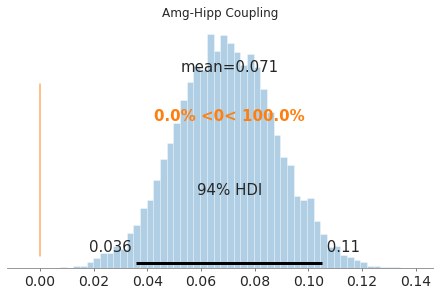

In [24]:
sns.set_style("ticks")
p = az.plot_posterior(trace_pe, var_names=['mu_coup'],
                 kind='hist', ref_val=0, point_estimate='mean')
p.set_title("Amg-Hipp Coupling")

In [28]:
sum(trace_pe.posterior.stack(draws=('chain','draw'))['mu_coup'].values > 0) / len(trace_pe.posterior.stack(draws=('chain','draw'))['mu_coup'].values)

0.999875

In [21]:
trace_pe

NameError: name 'trace_pe' is not defined

,n,r,CI95%,p-val,BF10,power
pearson,69,0.440904,"[0.23, 0.61]",0.00015,171.21,0.97193


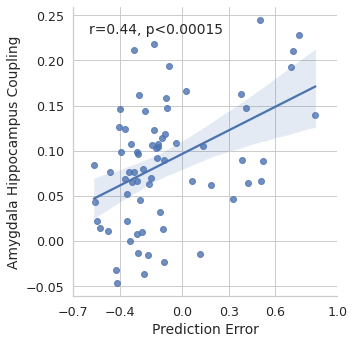

In [33]:
# visualization
# plot results
forPlot = df.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("whitegrid")
a = sns.lmplot(x ='pe', y='coupling', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala Hippocampus Coupling")
plt.text(-0.6,0.23, "r=0.44, p<0.00015")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
a.savefig('pe_coupling.png', dpi=300, bbox_inches='tight')
pg.corr(forPlot['pe'], forPlot['coupling'])

# Amygdala vmPFC

In [43]:
with pm.Model() as model1_vmpfc:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
   
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df['amg_vmpfc'])
    
    trace1_vmpfc = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 532 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [44]:
trStackedvmPFC = trace1_vmpfc.posterior.stack(draws=('chain','draw'))
csminus1 = trStackedvmPFC.b_cond[0,:].values
csplus1 = trStackedvmPFC.b_cond[1,:].values
csPlusUS1 = trStackedvmPFC.b_cond[2,:].values
csminus2 = trStackedvmPFC.b_cond[4,:].values
csplus2 = trStackedvmPFC.b_cond[3,:].values
csPlusUS2 = trStackedvmPFC.b_cond[5,:].values
csUSboth = np.mean(np.stack([csPlusUS1, csPlusUS2]), axis=0) # averaging across USs
csall = np.mean(np.stack([csminus1,csminus2, csplus1, csplus2]), axis=0) # averaging across CSs
usVcs = csUSboth - csall


Text(0.5, 1.0, 'CSPlusUS-CS in vmPFC')

<Figure size 1296x216 with 0 Axes>

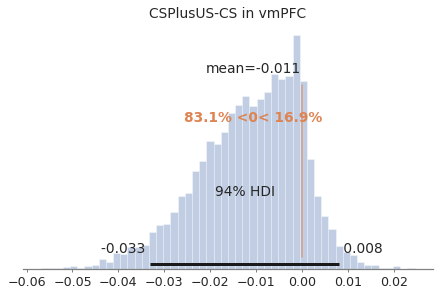

In [45]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(usVcs, point_estimate='mean', kind='hist', ref_val=0).set_title("CSPlusUS-CS in vmPFC")


In [46]:
print(f'Standardized coeficient {np.mean(usVcs) / np.std(usVcs)}')
az.summary(usVcs)

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


Standardized coeficient -0.9406397642280248


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-0.011,0.011,-0.033,0.008,0.0,0.0,4559.0,6503.0,NaN


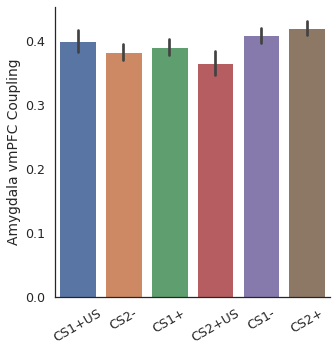

In [49]:
# visualization
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='amg_vmpfc',x='condition', data=df, kind='bar', ci=68)
g.set_xlabels("")
g.set_xticklabels(
    labels=["CS1+US", "CS2-", "CS1+", "CS2+US", "CS1-", "CS2+"], rotation=30)
g.set_ylabels("Amygdala vmPFC Coupling")
g.savefig('coupling_different_Conditions.png', dpi=300, bbox_inches='tight')

## SCR

In [ ]:
with pm.Model() as scr_vmpfc:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    #mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_vmpfc)
    
    mu = a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_vmpfc
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.scr)
   
    
    trace1_scr_vmpfc = pm.sample(target_accept=.98, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000, random_seed=145)  

In [ ]:
az.summary(trace1_scr_vmpfc, var_names=['b_coup','b_cond','b_matt'])

In [ ]:
az.plot_posterior(trace1_scr_vmpfc,var_names=['b_coup'], kind='hist', ref_val=0, point_estimate='mean')

## prediction error

In [5]:
with pm.Model() as model_pe_vmpfc:
    
    # adding intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    #b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    mu_coup = pm.Normal('mu_coup', mu=0, sigma=.5)
    sigma_coup = pm.HalfCauchy('sigma_coup', .5)
    coup_matt = pm.Normal('coup_matt', mu=0, sd=1, shape=n_sub)
    b_coup = pm.Deterministic('b_coup', mu_coup + sigma_coup*coup_matt)
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',intercept + a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup[subIDX]*df.amg_vmpfc)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace_pe_vmpfc = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 844 seconds.


In [6]:
az.summary(trace_pe_vmpfc, var_names=['mu_coup','b_coup','b_amg','mu_a'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_coup,-0.021,0.017,-0.053,0.009,0.000,0.000,18203.0,6267.0,1.0
b_coup[0],-0.011,0.033,-0.070,0.057,0.000,0.000,12464.0,6352.0,1.0
b_coup[1],-0.029,0.032,-0.090,0.035,0.000,0.000,12462.0,6277.0,1.0
b_coup[2],-0.015,0.032,-0.072,0.049,0.000,0.000,13743.0,6526.0,1.0
b_coup[3],-0.017,0.032,-0.077,0.047,0.000,0.000,16818.0,6068.0,1.0
...,...,...,...,...,...,...,...,...,...
b_coup[62],-0.013,0.032,-0.072,0.053,0.000,0.000,12738.0,5892.0,1.0
b_coup[63],-0.025,0.031,-0.084,0.036,0.000,0.000,14719.0,6435.0,1.0
b_coup[64],-0.017,0.031,-0.077,0.047,0.000,0.000,13075.0,5942.0,1.0
b_amg,-0.007,0.015,-0.032,0.022,0.000,0.000,18058.0,5181.0,1.0


array([<AxesSubplot:title={'center':'mu_coup'}>,
       <AxesSubplot:title={'center':'b_amg'}>], dtype=object)

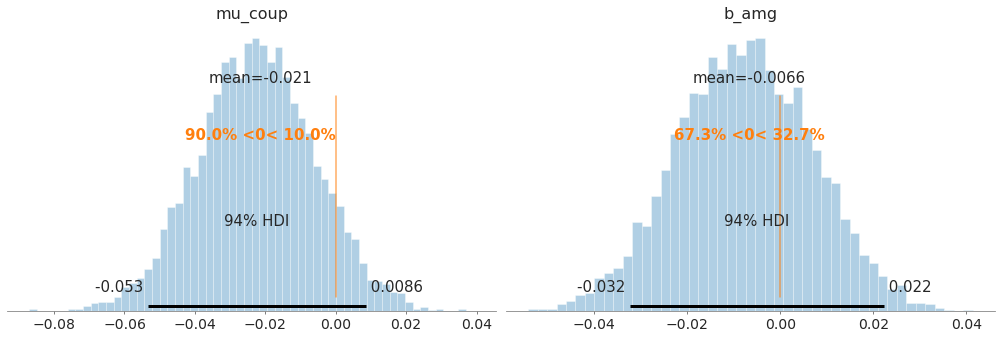

In [29]:
sns.set_style("ticks")
az.plot_posterior(trace_pe_vmpfc, var_names=['mu_coup','b_amg'], kind='hist',
                 ref_val=0)

## Amygdala and Anterior Hippocampus

In [7]:
with pm.Model() as model1_antHipp:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
   
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df['amg_HippAnt'])
    
    trace1_antHipp = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 544 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
trStackedantHip = trace1_antHipp.posterior.stack(draws=('chain','draw'))
csminus1 = trStackedantHip.b_cond[0,:].values
csplus1 = trStackedantHip.b_cond[1,:].values
csPlusUS1 = trStackedantHip.b_cond[2,:].values
csminus2 = trStackedantHip.b_cond[4,:].values
csplus2 = trStackedantHip.b_cond[3,:].values
csPlusUS2 = trStackedantHip.b_cond[5,:].values
csUSboth = np.mean(np.stack([csPlusUS1, csPlusUS2]), axis=0) # averaging across USs
csall = np.mean(np.stack([csminus1,csminus2, csplus1, csplus2]), axis=0) # averaging across CSs
usVcs = csUSboth - csall


Text(0.5, 1.0, 'CSPlusUS-CS in anterior Hippocampus')

<Figure size 1296x216 with 0 Axes>

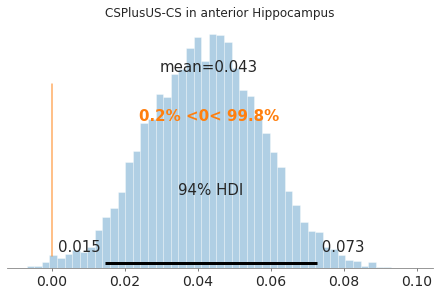

In [10]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(usVcs, point_estimate='mean', kind='hist', ref_val=0).set_title("CSPlusUS-CS in anterior Hippocampus")


In [11]:
print(f'Standardized coeficient {np.mean(usVcs) / np.std(usVcs)}')
az.summary(usVcs)

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


Standardized coeficient 2.7758577170553806


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.043,0.016,0.015,0.073,0.0,0.0,4754.0,3233.0,NaN


In [1]:
# visualization
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='coupling',x='condition', data=df, kind='bar', ci=68)
g.set_xlabels("")
g.set_xticklabels(
    labels=["CS+US", "CS-", "CS+", "CS+US", "CS-", "CS+"], rotation=30)
g.set_ylabels("Amygdala Anterior Hippocampus Coupling")
#g.savefig('coupling_different_Conditions.png', dpi=300, bbox_inches='tight')

NameError: name 'sns' is not defined

## SCR

In [14]:
with pm.Model() as scr_antHipp:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    eps = pm.HalfCauchy('eps', .5)
    
       
    mu = a[subIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.amg_HippAnt
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.scr)
   
    trace1_scr_antHipp = pm.sample(target_accept=.98, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000, random_seed=145)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 499 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [15]:
az.summary(trace1_scr_antHipp, var_names=['b_coup','b_cond','b_matt'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_coup,0.031,0.024,-0.013,0.078,0.000,0.000,6806.0,6050.0,1.0
b_cond[0],0.055,0.362,-0.646,0.706,0.007,0.005,2969.0,4257.0,1.0
b_cond[1],0.282,0.362,-0.397,0.959,0.007,0.005,2951.0,4198.0,1.0
b_cond[2],0.710,0.362,0.017,1.376,0.007,0.005,2973.0,4222.0,1.0
b_cond[3],0.262,0.363,-0.436,0.931,0.007,0.005,2994.0,4341.0,1.0
b_cond[4],0.357,0.363,-0.333,1.028,0.007,0.005,2992.0,4405.0,1.0
b_cond[5],0.568,0.363,-0.105,1.262,0.007,0.005,2984.0,4232.0,1.0
b_matt[0],-1.159,0.592,-2.310,-0.104,0.015,0.011,1531.0,2854.0,1.0
b_matt[1],-0.290,0.440,-1.134,0.529,0.011,0.008,1475.0,2942.0,1.0
b_matt[2],1.346,0.582,0.267,2.420,0.015,0.011,1545.0,2957.0,1.0


In [20]:
0.031/0.024

1.2916666666666667

<AxesSubplot:title={'center':'b_coup'}>

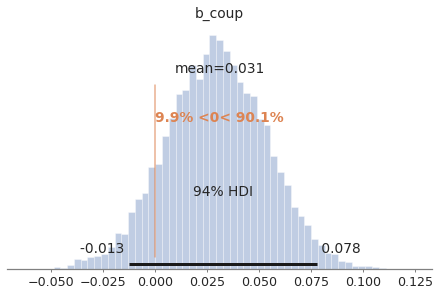

In [16]:
az.plot_posterior(trace1_scr_antHipp,var_names=['b_coup'], kind='hist', ref_val=0, point_estimate='mean')

## prediction error

In [17]:
with pm.Model() as model_pe_antHipp:
    
    # adding intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    #b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    mu_coup = pm.Normal('mu_coup', mu=0, sigma=.5)
    sigma_coup = pm.HalfCauchy('sigma_coup', .5)
    coup_matt = pm.Normal('coup_matt', mu=0, sd=1, shape=n_sub)
    b_coup = pm.Deterministic('b_coup', mu_coup + sigma_coup*coup_matt)
    
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',intercept + a[subIDX] + b_trials*trials + b_amg*df.amg + b_coup[subIDX]*df.amg_HippAnt)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace_pe_antHipp = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 868 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [18]:
az.summary(trace_pe_antHipp, var_names=['mu_coup','b_coup','b_amg','mu_a'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_coup,0.050,0.018,0.017,0.084,0.000,0.000,12097.0,6831.0,1.0
b_coup[0],0.033,0.059,-0.080,0.144,0.000,0.001,15649.0,6192.0,1.0
b_coup[1],0.048,0.060,-0.071,0.165,0.000,0.001,18495.0,5518.0,1.0
b_coup[2],0.087,0.059,-0.022,0.201,0.001,0.000,11205.0,6423.0,1.0
b_coup[3],0.062,0.060,-0.053,0.177,0.000,0.001,16897.0,6297.0,1.0
...,...,...,...,...,...,...,...,...,...
b_coup[62],0.028,0.061,-0.094,0.142,0.000,0.001,15361.0,5978.0,1.0
b_coup[63],0.114,0.066,0.005,0.245,0.001,0.001,6034.0,6105.0,1.0
b_coup[64],-0.014,0.071,-0.153,0.112,0.001,0.001,7159.0,5786.0,1.0
b_amg,-0.004,0.014,-0.030,0.024,0.000,0.000,20569.0,5686.0,1.0


In [21]:
0.05/0.018

2.777777777777778

array([<AxesSubplot:title={'center':'mu_coup'}>,
       <AxesSubplot:title={'center':'b_amg'}>], dtype=object)

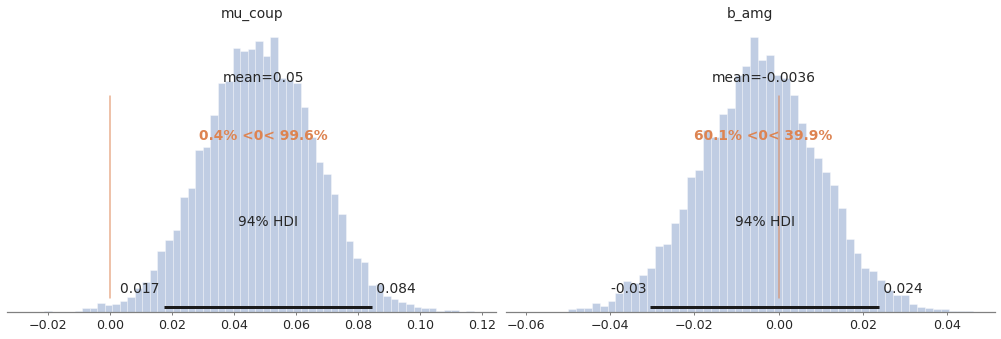

In [19]:
sns.set_style("ticks")
az.plot_posterior(trace_pe_antHipp, var_names=['mu_coup','b_amg'], kind='hist',
                 ref_val=0)

## Amygdala and Supramarginal Gyrus Left

In [8]:
from models import *

In [9]:
trace1_ctrl = conditionModel(n_sub, n_cond, subIDX, condIDX, trials, df, 'amg_ctrl')


KeyboardInterrupt



In [33]:
trStackedCtrl = trace1_ctrl.posterior.stack(draws=('chain','draw'))
csminus1 = trStackedCtrl.b_cond[0,:].values
csplus1 = trStackedCtrl.b_cond[1,:].values
csPlusUS1 = trStackedCtrl.b_cond[2,:].values
csminus2 = trStackedCtrl.b_cond[4,:].values
csplus2 = trStackedCtrl.b_cond[3,:].values
csPlusUS2 = trStackedCtrl.b_cond[5,:].values
csUSboth = np.mean(np.stack([csPlusUS1, csPlusUS2]), axis=0) # averaging across USs
csall = np.mean(np.stack([csminus1,csminus2, csplus1, csplus2]), axis=0) # averaging across CSs
usVcs = csUSboth - csall


Text(0.5, 1.0, 'CSPlusUS-CS in Supramarginal Gyrus')

<Figure size 1296x216 with 0 Axes>

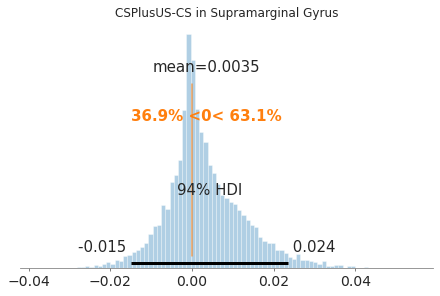

In [34]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(usVcs, point_estimate='mean', kind='hist', ref_val=0).set_title("CSPlusUS-CS in Supramarginal Gyrus")


In [35]:
print(f'Standardized coeficient {np.mean(usVcs) / np.std(usVcs)}')
az.summary(usVcs)

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


Standardized coeficient 0.3585686525082373


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.004,0.01,-0.015,0.024,0.0,0.0,8159.0,7416.0,NaN


In [36]:
trace_scr_ctrl = scrModel(n_sub, n_cond, subIDX, condIDX, trials, df, 'scr', 'amg_ctrl')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, b_coup, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 398 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [37]:
az.summary(trace_scr_ctrl, var_names=['b_coup','b_cond'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_coup,0.012,0.023,-0.032,0.055,0.000,0.000,8868.0,5520.0,1.0
b_cond[0],0.065,0.356,-0.617,0.712,0.006,0.004,3961.0,4407.0,1.0
b_cond[1],0.292,0.356,-0.385,0.943,0.006,0.004,3956.0,4368.0,1.0
b_cond[2],0.721,0.357,0.060,1.392,0.006,0.004,3941.0,4530.0,1.0
b_cond[3],0.274,0.358,-0.397,0.936,0.006,0.004,3962.0,4516.0,1.0
b_cond[4],0.368,0.358,-0.307,1.026,0.006,0.004,3971.0,4419.0,1.0
b_cond[5],0.581,0.358,-0.105,1.237,0.006,0.004,3932.0,4510.0,1.0


In [9]:
0.012/0.023

0.5217391304347826

Text(0.5, 1.0, 'SCR and Functional Connectivity of Amygdala and Supramarginal Gyrus left')

<Figure size 1296x216 with 0 Axes>

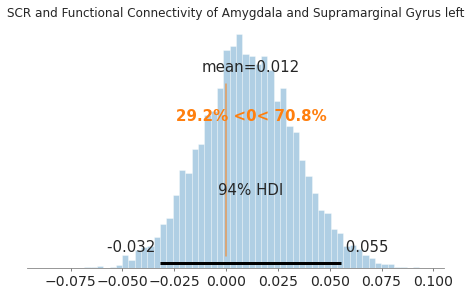

In [38]:
sns.set_style('ticks')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(trace_scr_ctrl, var_names='b_coup',
                  point_estimate='mean', kind='hist', ref_val=0).set_title("SCR and Functional Connectivity of Amygdala and Supramarginal Gyrus left")


In [10]:
trace_pe_ctrl = peModel(n_sub, n_cond, subIDX, condIDX, trials, df, 'amg_ctrl')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 841 seconds.


In [11]:
az.summary(trace_pe_ctrl, var_names=['mu_coup','b_coup','b_amg','mu_a'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_coup,0.000,0.015,-0.030,0.031,0.000,0.000,18390.0,5969.0,1.0
b_coup[0],-0.009,0.035,-0.087,0.058,0.000,0.000,12258.0,5957.0,1.0
b_coup[1],-0.002,0.034,-0.075,0.067,0.000,0.000,15132.0,5931.0,1.0
b_coup[2],-0.003,0.033,-0.070,0.067,0.000,0.000,13991.0,6422.0,1.0
b_coup[3],-0.011,0.036,-0.090,0.054,0.000,0.000,10819.0,5734.0,1.0
...,...,...,...,...,...,...,...,...,...
b_coup[62],0.005,0.034,-0.060,0.080,0.000,0.000,14744.0,6297.0,1.0
b_coup[63],0.004,0.033,-0.059,0.076,0.000,0.000,16857.0,6555.0,1.0
b_coup[64],0.003,0.034,-0.062,0.079,0.000,0.000,15103.0,6706.0,1.0
b_amg,-0.006,0.014,-0.034,0.021,0.000,0.000,20766.0,5871.0,1.0


In [10]:
0.006/0.016

0.375

<Figure size 1296x216 with 0 Axes>

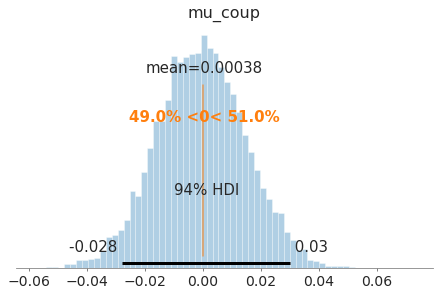

In [15]:
#sns.set_style('ticks')
sns.set_style('white')
fig = plt.figure(figsize=(18,3))
az.plot_posterior(trace_pe_ctrl, var_names='mu_coup',
                  point_estimate='mean', kind='hist', ref_val=0).figure.savefig('amg_supra_posterior.png')#.set_title("PE and Functional Connectivity of Amygdala and Supramarginal Gyrus left")


## Amygdala and mACC

In [8]:
trace_pe_macc = peModel(n_sub, n_cond, subIDX, condIDX, trials, df, 'amg_mAcc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 862 seconds.


array([[<AxesSubplot:title={'center':'mu_coup'}>,
        <AxesSubplot:title={'center':'mu_coup'}>],
       [<AxesSubplot:title={'center':'b_coup'}>,
        <AxesSubplot:title={'center':'b_coup'}>]], dtype=object)

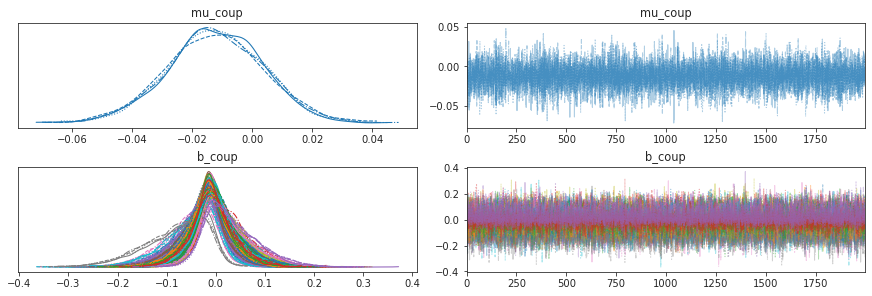

In [20]:
az.plot_trace(trace_pe_macc, var_names = ['mu_coup','b_coup'])

In [16]:
az.summary(trace_pe_macc, var_names='mu_coup')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_coup,-0.013,0.016,-0.043,0.018,0.0,0.0,16980.0,5853.0,1.0


In [31]:
0.012/0.016

0.75

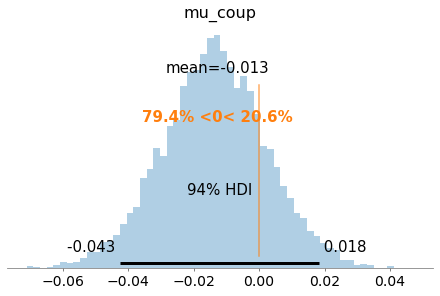

In [17]:
az.plot_posterior(trace_pe_macc, var_names = 'mu_coup', ref_val=0, kind='hist').figure.savefig('amg_acc_posterior.png')

,n,r,CI95%,p-val,BF10,power
pearson,69,-0.048917,"[-0.28, 0.19]",0.689781,0.163,0.068302


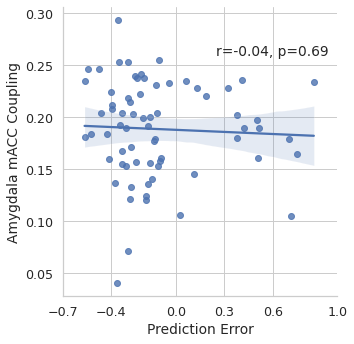

In [21]:
# visualization
# plot results
forPlot = df.groupby(['Event.Nr']).mean()
sns.set(font_scale = 1.15)
sns.set_style("whitegrid")
a = sns.lmplot(x ='pe', y='amg_mAcc', data= forPlot)
a.set_axis_labels("Prediction Error")
a.set_ylabels("Amygdala mACC Coupling")
plt.text(0.25,0.26, "r=-0.04, p=0.69")

a.set(xlim = (-0.7,0.95))
a.set(xticks=np.linspace(-0.7, 0.95, 6).round(1))
a.savefig('pe_coupling_acc.png', dpi=300, bbox_inches='tight')
pg.corr(forPlot['pe'], forPlot['amg_mAcc'])

# Comparing groups

In [6]:
df['group'] = df['group'].astype('category')

groupIDX = df['group'].cat.codes.values
groupIDX

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [16]:
df['group']

0       HC
1       HC
2       HC
3       HC
4       HC
        ..
4480    HC
4481    HC
4482    HC
4483    HC
4484    HC
Name: group, Length: 4485, dtype: category
Categories (3, object): ['HC', 'VCC', 'VPTSD']

## Different condition

In [26]:
# use reparametarization of the same model
# add hyperpriors
with pm.Model() as modelG:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    # add group
    group = pm.Normal('grp', mu=0, sigma=.5)
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + group*groupIDX + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.coupling)
    
    traceG = pm.sample(target_accept=.95, chains=4, cores=4, return_inferencedata=True, draws=2000, tune=2000, random_seed=123)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, grp, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 522 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [27]:
az.summary(traceG, var_names=['grp'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
grp,0.034,0.031,-0.023,0.093,0.001,0.001,501.0,1109.0,1.0


In [7]:
0.034/0.031


1.0967741935483872

In [8]:
# Different condition amg-vmpfc
with pm.Model() as modelG_vmpfc:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
    
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    # add group
    group = pm.Normal('grp', mu=0, sigma=.5)
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + group*groupIDX + b_cond[condIDX] + b_trials*trials + b_amg*df.amg)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.amg_vmpfc)
    
    traceG_vmpfc = pm.sample(target_accept=.95, chains=4, cores=4, return_inferencedata=True, draws=2000, tune=2000, random_seed=123)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, grp, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 770 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [9]:
az.summary(traceG_vmpfc, var_names=['grp'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
grp,-0.03,0.019,-0.065,0.006,0.0,0.0,1745.0,3001.0,1.0


## SCR and groups

In [10]:
with pm.Model() as model1_scrG:
    
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    mu_b = pm.Normal('mu_b', mu=0, sigma=.5)
    sigma_b = pm.HalfCauchy('sigma_b', .5)
    b_matt = pm.Normal('b_matt', mu=0, sigma=1, shape=n_cond)
    b_cond = pm.Deterministic('b_cond', mu_b + sigma_b*b_matt)
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    
    # add group
    group = pm.Normal('grp', mu=0, sigma=.5, shape=3)
   
  
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',a[subIDX] + group[groupIDX] + b_cond[condIDX] + b_trials*trials + b_amg*df.amg + b_coup*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.scr)
   
    
    trace_scrG = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, grp, b_coup, b_amg, b_trials, b_matt, sigma_b, mu_b, a_matt, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 580 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
az.summary(trace_scrG, var_names=['grp','b_coup', 'b_cond'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
grp[0],0.442,0.280,-0.099,0.955,0.006,0.004,1934.0,2768.0,1.0
grp[1],-0.061,0.278,-0.600,0.443,0.007,0.005,1797.0,2703.0,1.0
grp[2],-0.043,0.276,-0.561,0.461,0.006,0.004,2031.0,3281.0,1.0
b_coup,0.058,0.024,0.014,0.103,0.000,0.000,4399.0,4482.0,1.0
b_cond[0],0.020,0.388,-0.718,0.746,0.007,0.005,3222.0,4108.0,1.0
b_cond[1],0.248,0.388,-0.480,0.986,0.007,0.005,3281.0,3996.0,1.0
b_cond[2],0.672,0.389,-0.064,1.403,0.007,0.005,3301.0,4123.0,1.0
b_cond[3],0.231,0.389,-0.516,0.947,0.007,0.005,3305.0,4096.0,1.0
b_cond[4],0.325,0.389,-0.395,1.075,0.007,0.005,3259.0,3895.0,1.0
b_cond[5],0.532,0.389,-0.211,1.257,0.007,0.005,3283.0,3950.0,1.0


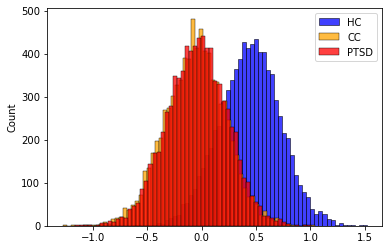

In [27]:
# seems to be differences between the groups
# lets examine
trStackedG = trace_scrG.posterior.stack(draws=('chain','draw'))
trHC = trStackedG.grp[0,:].values
trCC = trStackedG.grp[1,:].values
trPTSD = trStackedG.grp[2,:].values
sns.histplot(trHC, label = 'HC', color = 'blue')
sns.histplot(trCC, label= 'CC', color = 'orange')
sns.histplot(trPTSD, label = 'PTSD', color = 'red')
plt.legend()

In [28]:
TRccPTSD = np.mean(np.stack([trCC, trPTSD]), axis=0)
TRccPTSD.shape

(8000,)

In [29]:
HC_vs_CCPTSD = trHC - (np.mean(np.stack([trCC, trPTSD]), axis=0))
az.summary(HC_vs_CCPTSD)

arviz - WARNING - Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.494,0.122,0.269,0.727,0.005,0.003,676.0,1247.0,NaN


In [30]:
0.494/0.122

4.049180327868853

In [ ]:
sns.set_style("ticks")
az.plot_posterior(trace_scrG, var_names=['b_coup'], kind='hist', point_estimate='mean',
                 ref_val=0)

## Prediction error

In [32]:
with pm.Model() as model_peG:
    
    # adding intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    mu_a = pm.Normal('mu_a', mu=0, sigma=.5)
    sigma_a = pm.HalfCauchy('sigma_a', .5)
    a_matt = pm.Normal('a_matt', mu=0, sd=1, shape=n_sub)
    a = pm.Deterministic('a', mu_a + sigma_a*a_matt)
        
    
    # add trials and amygdala activation
    b_trials = pm.Normal('b_trials', mu=0, sigma=.5)
    b_amg = pm.Normal('b_amg', mu=0, sigma=.5)
    
    # add coupling
    #b_coup = pm.Normal('b_coup', mu=0, sigma=.5)
    mu_coup = pm.Normal('mu_coup', mu=0, sigma=.5)
    sigma_coup = pm.HalfCauchy('sigma_coup', .5)
    coup_matt = pm.Normal('coup_matt', mu=0, sd=1, shape=n_sub)
    b_coup = pm.Deterministic('b_coup', mu_coup + sigma_coup*coup_matt)
    
    # add group
    group = pm.Normal('grp', mu=0, sigma=.5, shape=3)
   
    eps = pm.HalfCauchy('eps', .5)
    
    # make mu a determenistic distribution so we can test later vs. actual data
    
    mu = pm.Deterministic('mu',intercept + a[subIDX] + group[groupIDX] + b_trials*trials + b_amg*df.amg + b_coup[subIDX]*df.coupling)
    
    y_hat = pm.Normal('y_hat', mu=mu, sigma=eps, observed=df.pe)
   
    
    trace_peG = pm.sample(target_accept=.95, chains=4, cores=10, return_inferencedata=True, draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, grp, coup_matt, sigma_coup, mu_coup, b_amg, b_trials, a_matt, sigma_a, mu_a, intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1054 seconds.


In [33]:
az.summary(trace_peG, var_names='grp')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
grp[0],-0.016,0.276,-0.549,0.490,0.004,0.003,4319.0,5334.0,1.0
grp[1],-0.021,0.276,-0.526,0.514,0.004,0.003,4341.0,5290.0,1.0
grp[2],0.006,0.276,-0.531,0.509,0.004,0.003,4334.0,5561.0,1.0


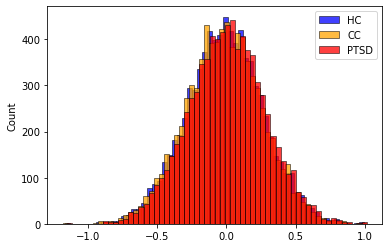

In [34]:
trStackedGpe = trace_peG.posterior.stack(draws=('chain','draw'))
trHC = trStackedGpe.grp[0,:].values
trCC = trStackedGpe.grp[1,:].values
trPTSD = trStackedGpe.grp[2,:].values
sns.histplot(trHC, label = 'HC', color = 'blue')
sns.histplot(trCC, label= 'CC', color = 'orange')
sns.histplot(trPTSD, label = 'PTSD', color = 'red')
plt.legend()